In [2]:
#Importing Libraries

#for pulling and formating data
import requests
import pandas as pd
import json

#for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.ticker import PercentFormatter

#For textual analysis
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
from textblob import TextBlob
from wordcloud import WordCloud
nltk.download('stopwords')
nltk.download('punkt')

pd.options.mode.chained_assignment = None




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lvpbbu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lvpbbu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


# Understand data and pull out product options

In [4]:
#Pull small sample
headers = {
    'accept': 'application/json',
}

params = (
    ('company_received_min', '2020-01-01'),
    ('company_received_max', '2023-12-31'),
    ('format', 'json'),
    ('state', 'MO'),
)

response = requests.get('https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/', headers=headers, params=params)


#Checking that request worked
print("Checking that data was pulled correctly.", '\n')
response.raise_for_status()
print('Pulling info', '\n', '\n')

#formating response as json
sample_data = response.json()
#De-nesting data
sample_data = pd.json_normalize(sample_data)

#List variable names in dataset
print('\033[1m'+'Variable Names'+'\033[0m', *list(sample_data.columns),sep='\n')
print('\n')

#Find products in databases
print('\033[1m'+ 'Products' + '\033[0m', *sample_data["_source.product"].unique(), sep='\n')



Checking that data was pulled correctly. 

Pulling info 
 

Variable Names
_index
_type
_id
_score
sort
_source.product
_source.complaint_what_happened
_source.date_sent_to_company
_source.issue
_source.sub_product
_source.zip_code
_source.tags
_source.complaint_id
_source.timely
_source.consumer_consent_provided
_source.company_response
_source.submitted_via
_source.company
_source.date_received
_source.state
_source.consumer_disputed
_source.company_public_response
_source.sub_issue


Products
Credit reporting, credit repair services, or other personal consumer reports
Mortgage
Debt collection
Payday loan, title loan, or personal loan
Credit card or prepaid card
Vehicle loan or lease
Checking or savings account
Money transfer, virtual currency, or money service
Student loan


# Subset relevant data for analysis

In [6]:
#Adjust parameters to pull another subset focused on a specific product 
headers = {
    'accept': 'application/json',
}

params = (
    ('company_received_min', '2012-01-01'),
    ('company_received_max', '2023-01-01'),
    ('product', 'Student loan'),
    ('state','MO'),
    ('format', 'json')
)

response = requests.get('https://www.consumerfinance.gov/data-research/consumer-complaints/search/api/v1/', 
                        headers=headers, params=params)


#Checking that request worked
print("Checking that data was pulled correctly.", '\n')
response.raise_for_status()
print('Pulling info...', '\n', '\n')

#formating response as json
data = response.json()
#De-nesting data
data = pd.json_normalize(data)
#show formatted data as pandas dataframes
print('Done!')
print('\033[1m'+ 'Data preview' + '\033[0m')
data

Checking that data was pulled correctly. 

Pulling info... 
 

Done!
Data preview


,_index,_type,_id,_score,sort,_source.product,_source.complaint_what_happened,_source.date_sent_to_company,_source.issue,_source.sub_product,...,_source.timely,_source.consumer_consent_provided,_source.company_response,_source.submitted_via,_source.company,_source.date_received,_source.state,_source.consumer_disputed,_source.company_public_response,_source.sub_issue
0,complaint-public-v2,_doc,2960230,None,[243],Student loan,We have been dealing with a company named Amer...,2018-07-11T12:00:00-05:00,Dealing with your lender or servicer,Federal student loan servicing,...,No,Consent provided,Closed with explanation,Web,Ameritech Financial,2018-07-11T12:00:00-05:00,MO,N/A,None,Don't agree with the fees charged
1,complaint-public-v2,_doc,3028474,None,[1035],Student loan,sending this complaint is student & Mother & F...,2018-09-26T12:00:00-05:00,Dealing with your lender or servicer,Private student loan,...,Yes,Consent provided,Closed with explanation,Web,DISCOVER BANK,2018-09-26T12:00:00-05:00,MO,N/A,None,Received bad information about your loan
2,complaint-public-v2,_doc,4727339,None,[2012],Student loan,I am in the PSLF program. FedLoan is saying ce...,2021-09-16T12:00:00-05:00,Dealing with your lender or servicer,Federal student loan servicing,...,Yes,Consent provided,Closed with non-monetary relief,Web,AES/PHEAA,2021-09-16T12:00:00-05:00,MO,N/A,None,Trouble with how payments are being handled
3,complaint-public-v2,_doc,3715972,None,[2555],Student loan,,2020-07-07T12:00:00-05:00,Struggling to repay your loan,Federal student loan servicing,...,Yes,Consent not provided,Closed with explanation,Web,AES/PHEAA,2020-06-25T12:00:00-05:00,MO,N/A,None,Can't get other flexible options for repaying ...
4,complaint-public-v2,_doc,2318121,None,[3376],Student loan,I was advised by customer service agents at Na...,2017-01-30T12:00:00-05:00,Dealing with my lender or servicer,Federal student loan servicing,...,Yes,Consent provided,Closed with explanation,Web,"Navient Solutions, LLC.",2017-01-30T12:00:00-05:00,MO,No,None,Received bad information about my loan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,complaint-public-v2,_doc,2889946,None,[709945],Student loan,On XX/XX/XXXX I filed a complaint against Neln...,2018-04-27T12:00:00-05:00,Dealing with your lender or servicer,Federal student loan servicing,...,Yes,Consent provided,Closed with explanation,Web,"Nelnet, Inc.",2018-04-27T12:00:00-05:00,MO,N/A,None,Received bad information about your loan
1176,complaint-public-v2,_doc,2984258,None,[711155],Student loan,,2018-08-07T12:00:00-05:00,Dealing with your lender or servicer,Private student loan,...,Yes,Consent not provided,Closed with explanation,Web,"Navient Solutions, LLC.",2018-08-07T12:00:00-05:00,MO,N/A,None,Received bad information about your loan
1177,complaint-public-v2,_doc,102439,None,[712175],Student loan,,2012-06-18T12:00:00-05:00,Repaying your loan,Non-federal student loan,...,Yes,N/A,Closed with explanation,Web,"Navient Solutions, LLC.",2012-06-15T12:00:00-05:00,MO,No,None,None
1178,complaint-public-v2,_doc,670019,None,[712642],Student loan,,2014-01-17T12:00:00-05:00,Dealing with my lender or servicer,Non-federal student loan,...,Yes,N/A,Closed with explanation,Web,AES/PHEAA,2014-01-15T12:00:00-05:00,MO,Yes,None,Having problems with customer service


# Explore cross-sectional and time-series variation

Summary Stats by Company
count    82.00
mean     14.39
std      62.23
min       1.00
25%       1.00
50%       1.00
75%       4.00
max     518.00
Name: _source.company, dtype: float64
AxesSubplot(0.125,0.11;0.775x0.77)


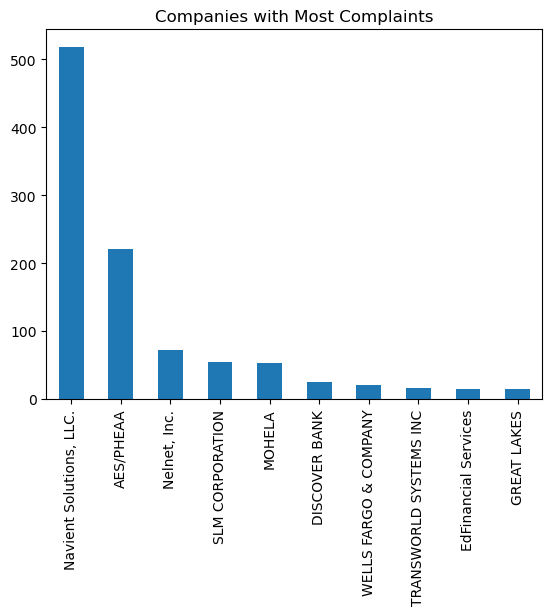

In [7]:
#Summarize frequency of companies
print('\033[1m' + 'Summary Stats by Company' + '\033[0m')
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(data["_source.company"].value_counts().describe())

#Graphing top 10 companies 
print(data["_source.company"].value_counts().head(10).plot(kind="bar", title="Companies with Most Complaints"))


Ranked complaints by issues
Dealing with your lender or servicer                                                430
Dealing with my lender or servicer                                                  285
Can't repay my loan                                                                 178
Struggling to repay your loan                                                       131
Repaying your loan                                                                   69
Incorrect information on your report                                                 37
Problems when you are unable to pay                                                  24
Getting a loan                                                                       18
Problem with a credit reporting company's investigation into an existing problem      4
Improper use of your report                                                           3
Problem with fraud alerts or security freezes                                         1
Name

<AxesSubplot:title={'center':'By Issue'}>

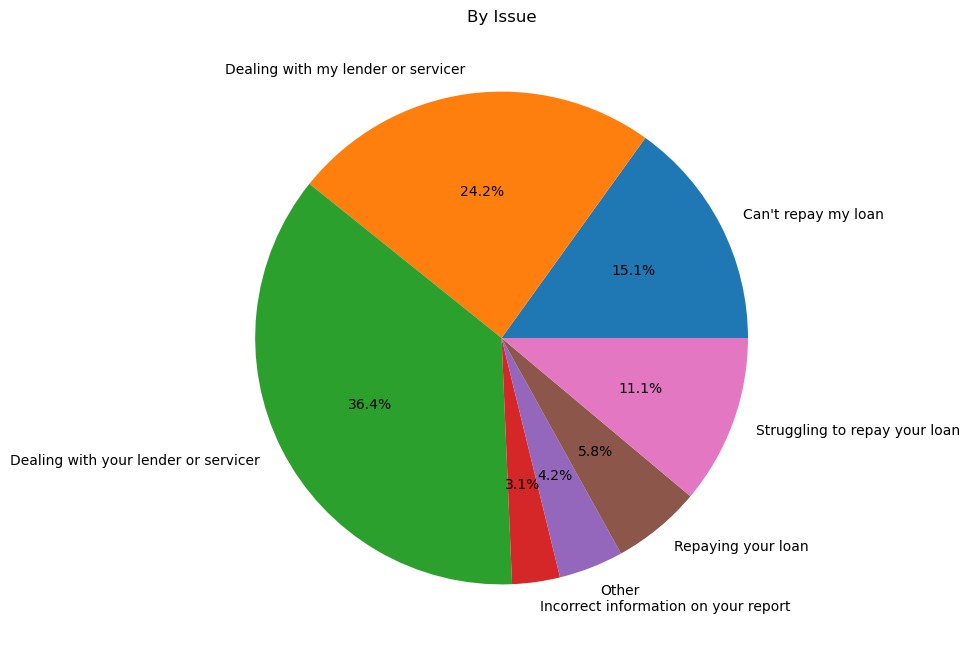

In [8]:
#Summarize types of issues
print('\033[1m' + 'Ranked complaints by issues' +'\033[0m')
print(data["_source.issue"].value_counts())

#Printing pie chart
pie=data['_source.issue'].value_counts()
value = (len(data)*.025)
pie.groupby(np.where(pie>=value,pie.index,'Other')).sum().plot.pie( title="By Issue", figsize=(8,8), ylabel='', 
                                                                autopct='%1.1f%%')




AxesSubplot(0.125,0.11;0.775x0.77)


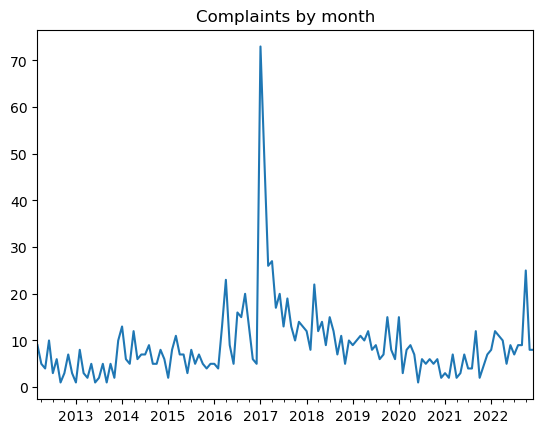

In [9]:
#Summarize time series of complaints

#Ensure date is in date format 
data["_source.date_sent_to_company"] = pd.to_datetime(data["_source.date_sent_to_company"]).dt.date
data['month'] = pd.to_datetime(data['_source.date_sent_to_company']).dt.to_period('M')
frequency = data['month'].value_counts()

#Plotting complaints by date 
print(frequency.sort_index().plot(title="Complaints by month"))

By Percentages 
 Yes   97.54
No     2.46
Name: _source.timely, dtype: float64
AxesSubplot(0.125,0.11;0.775x0.77)


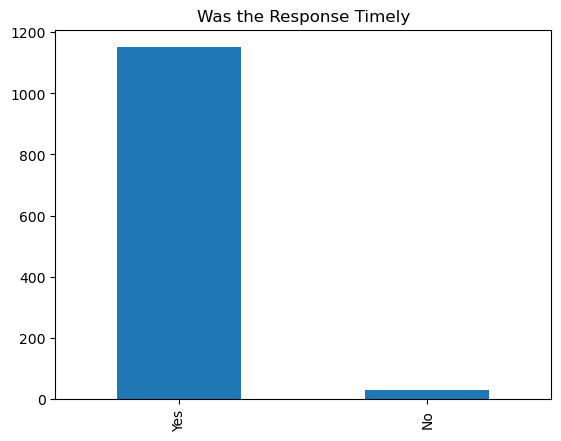

In [10]:
#Checking if response was timely 
print('\033[1m'+ 'By Percentages' + '\033[0m', '\n', data["_source.timely"].value_counts(normalize=True)*100)

print(data["_source.timely"].value_counts().plot(kind="bar", title="Was the Response Timely"))

# Looking at the Text of the Complaints

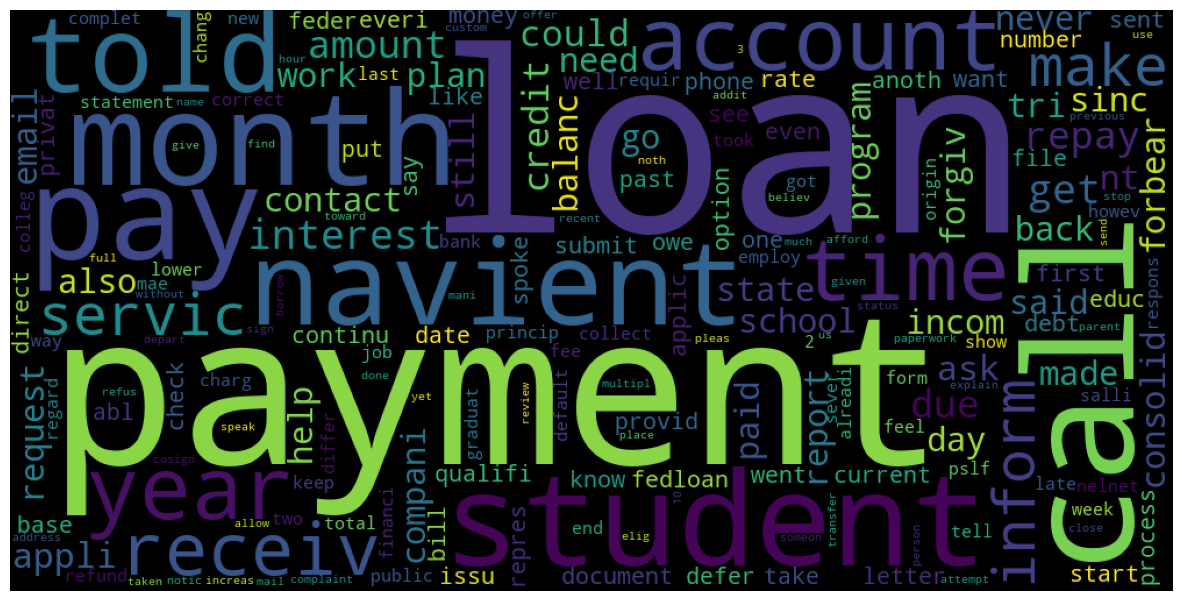

In [11]:
# Use English stemmer.
stemmer = SnowballStemmer("english")

#Removing Stopwords
extra_stops=["xxxx","xxxxxxxx","would"]
stoplist = stopwords.words('english') + extra_stops

narrative = data['_source.complaint_what_happened']

#Lowercase
narrative = narrative.apply(lambda x: " ".join(x.lower() for x in x.split()))
#Remove punct.
narrative = narrative.str.replace('[^\w\s]','',regex=True)
#Remove stopwords
narrative= narrative.apply(lambda x: ' '.join([word for word in x.split() if word not in (stoplist)]))
#Tokenize words
narrative = narrative.apply(word_tokenize)
#Stemming words
narrative = narrative.apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.

#Get frequencies
results=Counter()
narrative.apply(results.update)

#Creating wordcloud
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(results)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [12]:
narrative_bigrams = narrative.apply(lambda row: list(nltk.ngrams(row, 2)))
results_bigram = Counter()
narrative_bigrams.apply(results_bigram.update)

print('\033[1m'+ '20 Most Common Bigrams' + '\033[0m', *results_bigram.most_common(20), sep='\n')


20 Most Common Bigrams
(('student', 'loan'), 451)
(('loan', 'forgiv'), 143)
(('make', 'payment'), 137)
(('month', 'payment'), 129)
(('loan', 'payment'), 97)
(('interest', 'rate'), 95)
(('salli', 'mae'), 89)
(('repay', 'plan'), 83)
(('pay', 'loan'), 74)
(('public', 'servic'), 73)
(('consolid', 'loan'), 72)
(('credit', 'report'), 71)
(('servic', 'loan'), 67)
(('payment', 'plan'), 66)
(('loan', 'servic'), 66)
(('past', 'due'), 66)
(('custom', 'servic'), 59)
(('incom', 'base'), 57)
(('payment', 'made'), 55)
(('privat', 'loan'), 52)


# Sentiment Analysis

In [13]:
# function to calculate polarity
def getPolarity(review):
     return TextBlob(review).sentiment.polarity

# function to analyze the reviews
def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

data['Polarity'] = data['_source.complaint_what_happened'].apply(getPolarity) 
data['Pos/Neg?'] = data['Polarity'].apply(analysis)

data_with_narrative = data[data['_source.complaint_what_happened'] != '']

print('\033[1m'+ 'By Percentages' + '\033[0m', '\n', data_with_narrative["Pos/Neg?"].value_counts(normalize=True)*100)

pd.set_option('max_colwidth', 400)

data_with_narrative[["_source.complaint_what_happened", 'Polarity','Pos/Neg?']].sort_values("Polarity")

By Percentages 
 Positive   55.00
Negative   39.14
Neutral     5.86
Name: Pos/Neg?, dtype: float64


,_source.complaint_what_happened,Polarity,Pos/Neg?
365,"XXXX XXXX is out of business, degree is worthless.",-0.80,Negative
428,"This company is harassing my family about my loans. They declined to work with me when I lost my job. I called in XXXX to try to make a plan to help pay for my loans while I was unemployed and they refused to help. Since they wouldn't work with me, I was unable to pay them for 3 months. Now they are harassing my sister with phone calls. I never gave them her phone number and I have no idea how...",-0.57,Negative
500,I sent my student loan company Navient a Principal Payment in the amount of {$30000.00} and they have not credited my account. The check has cleared my bank account on XX/XX/2019 and I included a letter of instruction with my check. I believe there is fraud or embezzlement going on with Navient and they have stolen my money. This is money I have saved for a long time and worked very hard to ge...,-0.40,Negative
921,I took a loan out through sallie Mae in 2011 and have yet to pay off a {$2500.00} loan. They keep hiking interest rates and late fees and I 'm very sick of it. I ca n't afford it. Then they call my number all the time when I 'm maybe two days late and wo n't stop until they 're payment is processed and that 's not short timing by no means. It 's harassment. I encourage people to not go to coll...,-0.38,Negative
1001,Its very hard trying to pay my loan monthly all the fees they added,-0.38,Negative
...,...,...,...
1054,I have been struggling to make payments so last year I tried filing for repayment plan based on income which was n't successful. I have been making the monthly payments now for a year but they havent made a dent if anything my loans are increasing this has been going on now for 8 years,0.38,Positive
123,School XXXX XXXX Lender XXXX XXXX XXXX XXXX Guarantor XXXX XXXX XXXX/NAVIENT Disbursement Date XX/XX/XXXX Original Principal {$6000.00} XXXX XXXX Lender XXXX XXXX XXXX XXXX Guarantor XXXX XXXX XXXX/NAVIENT Disbursement Date XX/XX/XXXX Original Principal {$1000.00} School XXXX XXXX Lender XXXX XXXX XXXX XXXX Guarantor XXXX XXXX XXXX/NAVIENT Disbursement Date XX/XX/XXXXXX/XX/XXXX Origi...,0.38,Positive
378,"Last year XXXX the Department of Treasury was holding money out of my XXXX check and then stop around XXXX of XXXX. I called them and was told that my student loans where paid off, i asked if there was any more student loans. I was told no that they did not have any more loans. I was inform to call PHEAA and US Department of Education and ask both companies if I had any more student loans, the...",0.42,Positive
650,"I start attending XXXX XXXX XXXX XXXX XXXX College fall XX/XX/XXXX and continue to spring XX/XX/XXXX. I completed the In school Deferment Request for both semesters, yet Nelnet continue to bill me while attending school. I paid on my school loan during my deployments, when I did not have too. Do not understand way Nelnet is ignoring my request for deferment. I must return to school because I n...",0.50,Positive


count   580.00
mean      0.01
std       0.13
min      -0.80
25%      -0.05
50%       0.01
75%       0.08
max       0.50
Name: Polarity, dtype: float64


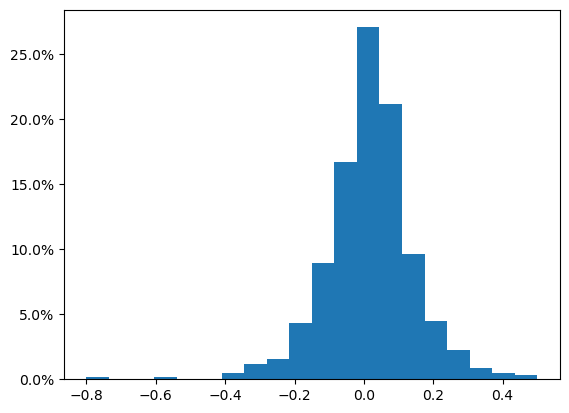

In [14]:
plt.hist(data_with_narrative["Polarity"], 
         weights=np.ones(len(data_with_narrative["Polarity"])) / len(data_with_narrative["Polarity"]),
         bins=20)


plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

print(data_with_narrative["Polarity"].describe())


# Comparing with other datasets

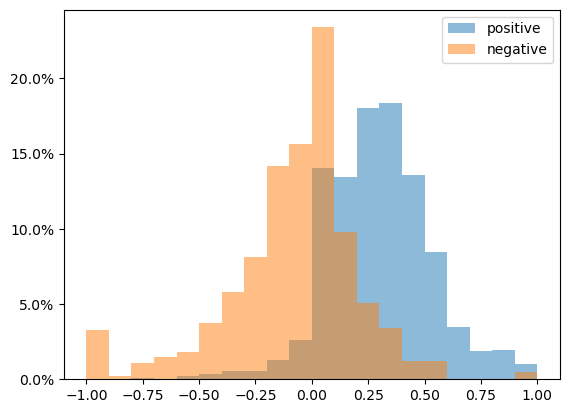

In [15]:
#hotels dataset from https://data.world/datafiniti/hotel-reviews

hotel_reviews = pd.read_csv('hotel_reviews-sub.csv')

#Subset into 2 datasets; one positive, one negative hotel reviews
hotel_reviews_pos = hotel_reviews[hotel_reviews['reviews.rating'] == (4 or 5)]
hotel_reviews_pos["reviews.text"] = hotel_reviews_pos["reviews.text"].apply(lambda x: str(x))
hotel_reviews_neg = hotel_reviews[hotel_reviews['reviews.rating'] == (1 or 2)]
hotel_reviews_neg["reviews.text"] = hotel_reviews_neg["reviews.text"].apply(lambda x: str(x))

#Create variables Polarity and Neg/Pos?
hotel_reviews_pos['Polarity'] = hotel_reviews_pos["reviews.text"].apply(getPolarity) 
hotel_reviews_pos['Neg/Pos?'] = hotel_reviews_pos['Polarity'].apply(analysis)
hotel_reviews_neg['Polarity'] = hotel_reviews_neg["reviews.text"].apply(getPolarity) 
hotel_reviews_neg['Neg/Pos?'] = hotel_reviews_neg['Polarity'].apply(analysis)

#Plot + and - hotel reviews in overlayed histograms
plt.hist(hotel_reviews_pos["Polarity"], weights=np.ones(len(hotel_reviews_pos["Polarity"])) / 
         len(hotel_reviews_pos["Polarity"]),
         bins=20, alpha=0.5)

plt.hist(hotel_reviews_neg["Polarity"], weights=np.ones(len(hotel_reviews_neg["Polarity"])) / 
         len(hotel_reviews_neg["Polarity"]),
         bins=20, alpha =0.5)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Add a legend
plt.legend(('positive', 'negative'), loc='upper right')



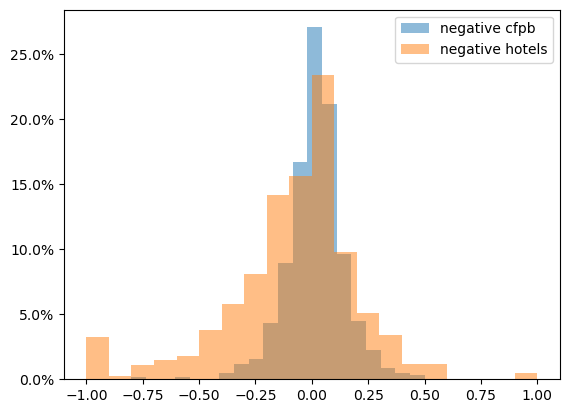

In [16]:
#Plot complaints and - hotel reviews in overlayed histograms
plt.hist(data_with_narrative["Polarity"], weights=np.ones(len(data_with_narrative["Polarity"])) / 
         len(data_with_narrative["Polarity"]),
         bins=20,alpha =0.5)
plt.hist(hotel_reviews_neg["Polarity"], weights=np.ones(len(hotel_reviews_neg["Polarity"])) / 
         len(hotel_reviews_neg["Polarity"]),
         bins=20, alpha =0.5)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))


plt.legend(('negative cfpb', 'negative hotels'), loc='upper right')

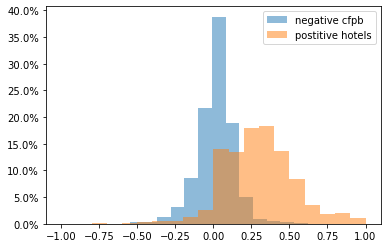

In [171]:
#Plot complains and + hotel reviews in overlayed histograms
plt.hist(data_with_narrative["Polarity"], weights=np.ones(len(data_with_narrative["Polarity"])) / 
         len(data_with_narrative["Polarity"]),
         bins=20,alpha =0.5)

plt.hist(hotel_reviews_pos["Polarity"], weights=np.ones(len(hotel_reviews_pos["Polarity"])) / 
         len(hotel_reviews_pos["Polarity"]),
         bins=20, alpha=0.5)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.legend(('negative cfpb', 'postitive hotels'), loc='upper right')